In [ ]:
import pandas as pd
import json
import random
import requests
import numpy as np
from chonkie import RecursiveChunker, LateChunker


In [21]:
import pandas as pd
import json
import random

## 1. CEX Goldstandard dataset Overview

* https://zenodo.org/records/10535653
* There are 112 English papers in 27 categories. 

In [22]:
pdf_df = pd.read_csv("pdf_files_info.csv")
references_data = json.load(open("all_references.json", "r", encoding="utf-8"))

print('CEX Goldstandard dataset:')
print(f"Total documents: {len(pdf_df)}")
print(f"Total categories: {len(pdf_df['category'].unique())}")
print(f"Total pages: {pdf_df['page_count'].sum()}")
# if references key exists: 
print(f"Total references: {sum(len(data['references']) if 'references' in data else 0 for data in references_data.values())}")

CEX Goldstandard dataset:
Total documents: 112
Total categories: 27
Total pages: 1581
Total references: 5160


In [23]:
def get_sample_data(pdf_df, references_data, sample_size=5):
    if not pdf_df.empty:
       print(f'\n=== SAMPLE PDF DATA ===')
       print(pdf_df.sample(sample_size).to_string(index=False))
    
    if references_data:
       print(f'\n=== SAMPLE REFERENCES DATA ===')
       sample_keys = list(references_data.keys())[:sample_size]
       for i, file_id in enumerate(sample_keys):
           ref_data = references_data[file_id]
           print(f"Paper {i+1} (ID: {file_id}):")
           print(f"  Number of references: {len(ref_data['references'])}")
           print(f"  First few references:")
           for j, ref in enumerate(ref_data['references'][:3]):
               print(f"    {j+1}. {ref}")
           if len(ref_data['references']) > 3:
               print(f"    ... and {len(ref_data['references']) - 3} more")
           print()

get_sample_data(pdf_df, references_data)


=== SAMPLE PDF DATA ===
    file_id        filename category                               file_path  page_count                                                                                                                                                                                                                                                                                                                                                                                                                                                    title  publication_year                                   doi                                                                                                                           xml_title                              journal       publisher
 CHE-ENG_17  CHE-ENG_17.pdf  CHE-ENG  benchmarks/cex/all_pdfs/CHE-ENG_17.pdf          10 Jumaidin, R., Sutan Saidi, Z. A., Ahmad Ilyas, R., Ahmad, M. N., Wahid, M. K., Yaakob, M. Y., Maidin, N. A., Ab Rah

<Axes: ylabel='Frequency'>

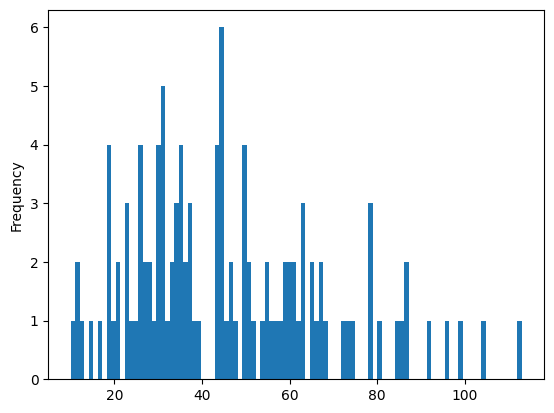

In [24]:
pdf_df['reference_count'] = pdf_df['file_id'].map(lambda x: len(references_data[str(x)]['references']))
pdf_df['reference_count'].plot(kind='hist', bins=100)

<Axes: ylabel='Frequency'>

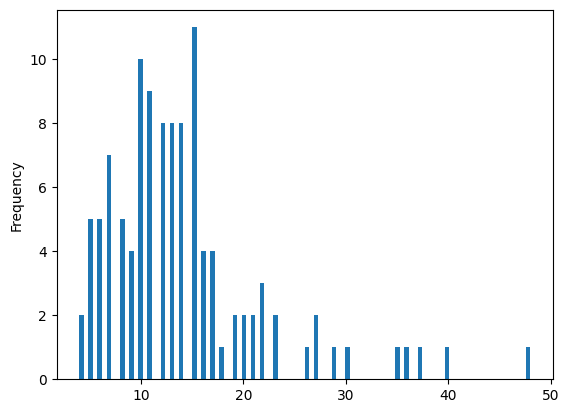

In [25]:
pdf_df['page_count'].plot(kind='hist', bins=100)

# Checking Sliver data for Original ref string


In [26]:
gt_file = 'all_references.json'
sliver_file = 'all_references_sliver.json'
gt_data = json.load(open(gt_file, 'r', encoding='utf-8'))
random.sample(list(gt_data.keys()), 5)

['VET_105', 'COM-SCI_25', 'NEU_83', 'NUR_85', 'MAT-SCI_66']

In [27]:
import random


def check_random_ref_string(n=5, n_ref=5):
    gt_file = 'all_references.json'
    sliver_file = 'all_references_sliver.json'
    gt_data = json.load(open(gt_file, 'r', encoding='utf-8'))
    sliver_data = json.load(open(sliver_file, 'r', encoding='utf-8'))

    # select n random file names from the gold standard
    random_files_names = random.sample(list(gt_data.keys()), n)
    for file_name in random_files_names:
        # file_id = int(file_name)
        gt_references = gt_data[file_name]['references']
        sliver_references = sliver_data[file_name]['references']
        
        # Check if the sliver references are a subset of the gold standard references
        if len(sliver_references) == len(gt_references):
            print(f"File {file_name} has the same number of references in both gold standard and sliver.")
        else:
            print(f"File {file_name} has a different number of references in gold standard and sliver.")
        
        print(f"checking random reference string to see if match")
        ref_id = random.sample(list(range(len(gt_references))), n_ref)
        for i in ref_id:
            print("--------------------------------")
            print(f"gold standard reference: {gt_references[i]}")
            print(f"sliver reference: {sliver_references[i]}")
            # print("--------------------------------")
        print("================================================")


check_random_ref_string()

        

File PHA-TOX-PHA_92 has the same number of references in both gold standard and sliver.
checking random reference string to see if match
--------------------------------
gold standard reference: W Sun, B Zhang, X Yu, C Zhuang, X Li, J Sun, Y Xing, Z Xiu, Y Dong. Oroxin A from Oroxylum indicum prevents the progression from prediabetes to diabetes in streptozotocin and high-fat diet induced mice. Phytomedicine. 2018. Vol. 38
sliver reference: Sun, W.; Zhang, B.; Yu, X.; Zhuang, C.; Li, X.; Sun, J.; Xing, Y.; Xiu, Z.; Dong, Y. Oroxin A from Oroxylum indicum prevents the progression from prediabetes to diabetes in streptozotocin and high-Fat diet induced mice. *Phytomedicine* **2018**, *38*, 24–34. [CrossRef](http://dx.doi.org/10.1016/j.phymed.2017.10.003)
--------------------------------
gold standard reference: J H Yang, S S Cho, K M Kim, J Y Kim, Eun Joo Kim, E Y Park, J H Lee, S H Ki. Neoagarooligosaccharides enhance the level and efficiency of LDL receptor and improve cholesterol home

# RAG experiment

In [2]:


test_file = '/Users/alex/docs/code/Odoma/citation_index/benchmarks/cex/all_markdown/AGR-BIO-SCI_1_marker.md'
# test_file = '/Users/alex/docs/code/Odoma/citation_index/benchmarks/excite/all_markdown/28878_marker.md'
# test_file = '/Users/alex/docs/code/Odoma/citation_index/benchmarks/excite/all_markdown/4605_marker.md'

# read md 
with open(test_file, 'r') as file:
    text = file.read()

from citation_index.core.segmenters.semantic_reference_locator import locate_reference_sections_semantic
from chonkie import LateChunker

chunker = LateChunker.from_recipe("markdown", lang="en", chunk_size=1500, min_characters_per_chunk=24)
locate_reference_sections_semantic(text, chunker)


Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 256). Running this sequence through the model will result in indexing errors
/opt/homebrew/Caskroom/miniforge/base/envs/citation_index/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniforge/base/envs/citation_index/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniforge/base/envs/citation_index/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


'### Discussion\n\nIn the WQP the duration of pasture access is used as a measure for the criterion expression of other behaviors and is rated high in the calculation of the overall farm welfare status. If farms provide access for more than 6 h per day, they are scored based on the number of days/year and hours/day on pasture, while farms with less than 6 h pasture access per day receive zero points. For the purpose of this study, it was consequently not plausible to include this measure, because pasture access depended on the study design. Consequently, results are presented at criteria and indicator level, without aggregating data to principle level or overall classification.\n\nHolistic welfare assessments using the WQP of dairy cows comparing different housing systems are still rare. The protocol was used in studies of Gieseke et al ([2018\\)](#page-11-0), De Graaf et al. ([2017](#page-10-0) and [2018\\)](#page-10-0), Andreasen et al. ([2013\\)](#page-10-0), Heath et al. [\\(2014](